# Resnet34 train on AWA2

Ensure any edits to libraries are reloaded here automatically. Use `matplotlib inline` to display any charts or images inline in the notebook.

In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import fastai packages. Use [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions which enable quick and easy building of neural networks and training models.

In [27]:
from fastai import *
from fastai.vision import *

Batchsize is critical when training models. On my system (gpu: GTX 1080 ti, ram: 2*16 GB) with bs = 32, it would quickly run out of memory!

In [28]:
bs = 16

## Loading AWA2 dataset

AWA2 (Animals with Attributes) is a benchmark dataset for transfer learning algorithms such as zero-shot learning. It consists of 37322 images of 50 animals and size of AwA2-data.zip is 13GB! The images in the dataset are in JPEG format.

I downloaded and extracted the dataset on my system. It took a total of 10 hours to download the entire data! 
The data is in the following format:
```
path/
    JPEGImages\
        antelope\
            antelope_10001.jpg
            antelope_10002.jpg
            ...
        bobcat\
            bobcat_10001.jpg
            bobcat_10002.jpg
            ...
        .
        .
        .
        classes.txt
```
classes.txt contains names of all the 50 animal categories, one per line.

I am currently training on a subset of AwA2 to speedup the process. I have selected 15 classes - `'beaver', 'killer+whale', 'horse', 'dalmatian', 'german+shepherd', 'mole', 'hippopotamus', 'antelope', 'grizzly+bear', 'siamese+cat', 'leopard', 'blue+whale', 'skunk', 'tiger', 'persian+cat'` - with 300 images in each class. Train / dev split is 90 : 10.

In [29]:
path = Path(f'/home/nik/data/Animals_with_Attributes2_small'); path

PosixPath('/home/nik/data/Animals_with_Attributes2_small')

In [30]:
path.ls()

[PosixPath('/home/nik/data/Animals_with_Attributes2_small/models'),
 PosixPath('/home/nik/data/Animals_with_Attributes2_small/train'),
 PosixPath('/home/nik/data/Animals_with_Attributes2_small/valid')]

## Dataloader and Data Augmentation

Fastai provides convenience methods to create `DataBunch` objects which can be used for training a classifier.

With `get_transforms()`, fastai applies a bunch of transforms (pixel and co-ordinate - flip, rotate, warp, zoom, lighting transforms) in an optimized way. The `get_transforms()` function returns a tuple of two list of transforms, one for the training set and the other for the validation set(limited to center crop by default).

In [31]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs)
data.normalize(imagenet_stats)

To take a peek at the images inside a batch, use `ImageDataBunch.show_batch`, _rows_ argument indicates number of rows and columns to display.

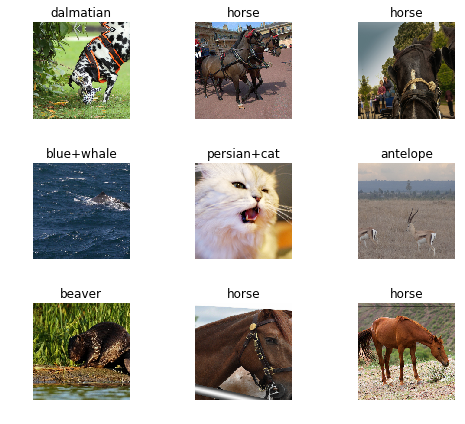

In [32]:
data.show_batch(rows=3, figsize=(7,6))

In [33]:
print(data.classes)
len(data.classes),data.c

['beaver', 'killer+whale', 'horse', 'dalmatian', 'german+shepherd', 'mole', 'hippopotamus', 'antelope', 'grizzly+bear', 'siamese+cat', 'leopard', 'blue+whale', 'skunk', 'tiger', 'persian+cat']


(15, 15)

## Model Training: resnet34

Fastai uses [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. The idea here is the model will take images as input and will output the predicted probability for each of the 15 categories.

This method creates a `Learner` object from the passed `DataBunch` object and backbone provided in the `arch`. It also cuts the model defined by `arch`(pretrained on Imagenet) at the last convolutional layer by default.

I am training for 4 epochs (4 cycles through all our data) with valid_loss at 0.078997 and accuracy at 96.67%.

In [34]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [35]:
learn.fit_one_cycle(4)

Total time: 15:20
epoch  train_loss  valid_loss  error_rate
1      0.396881    0.128516    0.044444    (03:49)
2      0.265760    0.120987    0.042222    (03:49)
3      0.241882    0.085652    0.033333    (03:51)
4      0.163190    0.078997    0.033333    (03:49)



## Saving the model

In [36]:
learn.save('stage-1')

## Results

`from_learner` is a factory method to instantiate `ClassificationInterpretation` which provides a confusion matrix and visualization for misclassified images. It uses the dev set and does not do any test time augmentation by default.

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

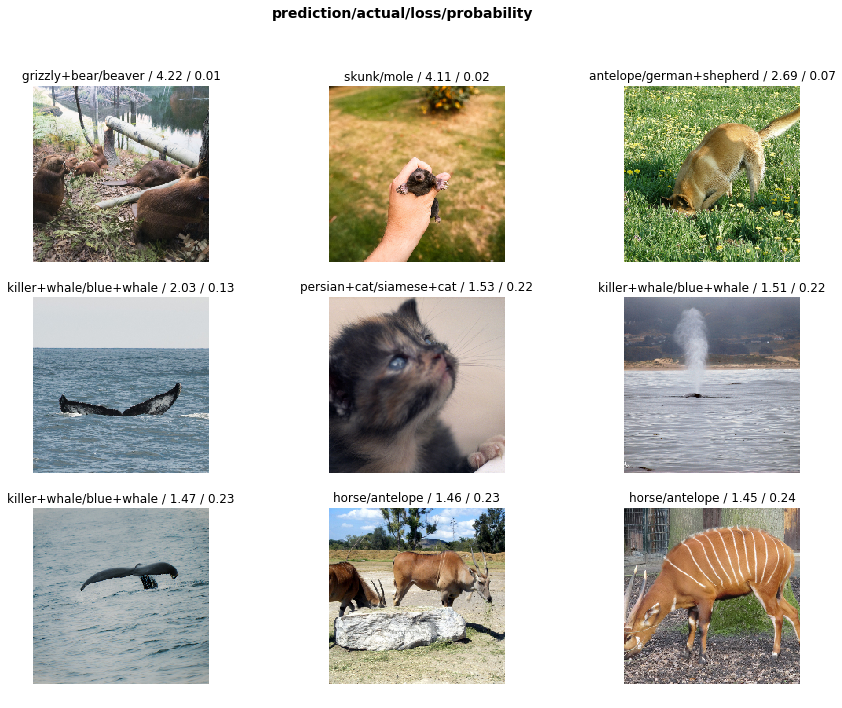

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

Plotting the confusion matrix helps identify which categories were confused with other categories and how often!

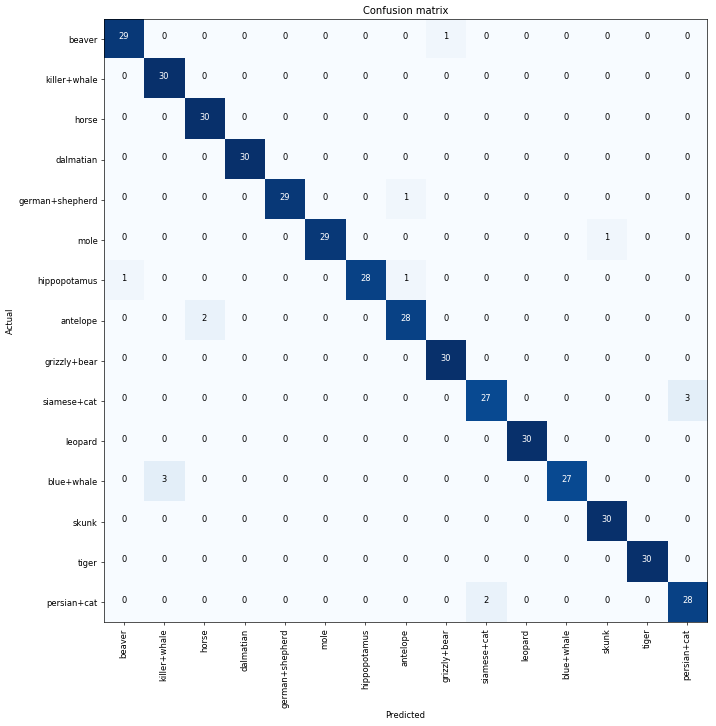

In [45]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [39]:
interp.most_confused(min_val=2)

[('siamese+cat', 'persian+cat', 3), ('blue+whale', 'killer+whale', 3)]

## Unfreezing and fine-tuning

*unfreeze* the model and train some more.

In [40]:
learn.unfreeze()

In [41]:
learn.fit_one_cycle(1)

Total time: 05:11
epoch  train_loss  valid_loss  error_rate
1      1.355557    0.871869    0.302222    (05:11)



In [42]:
learn.load('stage-1')

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7f984f16d4a8>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [43]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


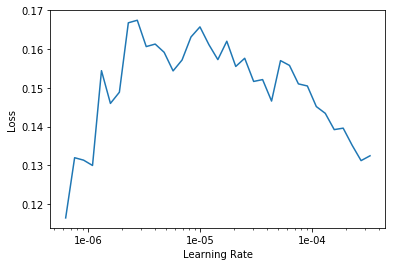

In [44]:
learn.recorder.plot()

In [46]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-4))

Total time: 10:23
epoch  train_loss  valid_loss  error_rate
1      0.367288    0.280402    0.084444    (05:11)
2      0.188406    0.112817    0.035556    (05:12)



Model Accuracy is 96.44%